# Notebook to make plots for figure 4

by Cascade Tuholske 2020.04.06

**Pick a city of geography & Year ... 1987-1988 W Africa, 1998 India & 2003 Europe** <br>
Cities : 12080 Hongcong, 9691 Kolkata, 8050 Bangalore, 1910 Accra, 2484 Lagos, 2046 Paris, 2987 Rome,
2559 Milan, 1887 bordeaux, 2135 Brussels <br>

Helpful for julian days: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [117]:
#### Dependencies
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates


In [2]:
#### Heat Index Data 
DATA_IN = '/home/cascade/projects/UrbanHeat/data/interim/ERA5_HI/' # output from avg temp
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'

In [3]:
def make_data(dir_in, geog, location):
    """Function makes data to plot daily city-level HI Max and average
    Args:
        dir_in = directory to get data
        geog = column for geography, city-level = 'ID_HDC_G0'
        location = usually a city id
    """
    
    fn_list = sorted(glob.glob(dir_in+'*.csv')) # get data
    df_out = pd.DataFrame() # to write dataframe
    
     # get leap year cols from 2016
    hi16 = pd.read_csv(fn_list[33]) 
    cols = list(hi16.iloc[:,3:].columns)
    cols = [year[5:] for year in cols] # cols for data frame
    
    temp_list = [] # empty list for temps
    
    # loop through dir and get data
    for i, fn in enumerate(fn_list):
        df = pd.read_csv(fn) # open data frame
        year_label = [(df.columns[3]).split('.')[0]] # get year
        row = df[df[geog] == location]
        temp = row.iloc[:,3:] # get only temp columns
        
        # add in col for leap years
        if temp.shape[1] == 365:
            temp.insert(loc = 59, column = year_label[0]+'.02.29', value = np.nan, allow_duplicates=False)

        # Set Index & Columns
        temp.index = year_label
        temp.columns = cols # revalue to m.d
    
        # add to list
        temp_list.append(temp)
    
    df_out = pd.concat(temp_list) # make one big dataframe
    
    return df_out
    

In [104]:
def plot_data(df, year, start, end):#, start, end):
    """ Make the data for a plot
    Args: 
        df = df w/ daily HI max for a given city
        year = year you want to plot against average
        start = start of plot in julian days (e.g 1 - 365/366)
        end = end of plot in julian days
    """

    # Deal with leap year
    if year % 4 !=0:
        df.drop(columns ='02.29', inplace = True)
    
    # Subset data
    start = start - 1 # zero indexing 
    subset = df.iloc[:,start:end]
    
    # HI Max for year
    hi_year = subset.loc[str(year)]
    
    # make 34-avg daily hi
    means = subset.mean(axis = 0)
    
    # make colums to date time
    cols = pd.to_datetime([str(year)+'.'+date for date in hi_year.index])
    
    return hi_year, means, cols


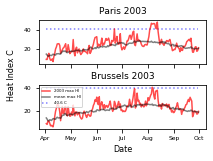

In [124]:
#### Make Figure & Save it

#### Args
city_list = [tuple((2045, 'Paris')), tuple((2145, 'Brussels'))]
year = 2003
font_size = 9

# April 1 to Sep 30
start = 93 
end = 274

# Labels
hi_label = str(year)+' max HI'
labels = [hi_label, 'mean max HI', '40.6 C']

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(2, 1, figsize = (3, 2), sharex=True)
ws = 0.5
fig.subplots_adjust(hspace=ws)

## Plot 1 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[0][0])
hi_year, means,cols = plot_data(data, year, start, end) 
axs[0].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[0].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[0].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[0].set_title(city_list[0][1]+' '+str(year), fontsize = font_size)
axs[0].tick_params(axis='both', labelsize = 6)

## Plot 2 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[1][0])
hi_year, means, cols = plot_data(data, year, start, end) 
axs[1].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[1].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[1].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[1].set_title(city_list[1][1]+' '+str(year), fontsize = font_size)

# ticks
# Make ticks on occurrences of each month:
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs[1].tick_params(axis='both', labelsize = 6)
#axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
fig.text(0,0.5, "Heat Index C", ha="center", va="center", rotation=90, fontsize = 8)
plt.xlabel('Date', fontsize = 8)


# Legend
plt.legend(labels, loc=2, prop={'size': 4})

# Save it out
plt.savefig(FIG_OUT+'TEST.png', dpi = 300, bbox_inches='tight')
